# Kessler Rules model for Sorted Circles

In [197]:
import numpy as np
import matplotlib.pyplot as plt

## Setting up the Grids
Only work in 2-D case for now.

In [208]:
# Setting constants
nx = 5
nz = 10
dx,dz = 0.2,0.1
T_a = -40 #temperature of atmosphere
T_0 = 2 #Temperature of soil initially
h_stones = 1 # thickness of stone layer
porosity = 0.1 #porosity of soil (represented as fraction of void cells in fines domain)
rho_water = 1000 #density kg/m3
rho_fines = 1600 #density kg/m3

# Heat capacity and specific heat:
cp_fines = 800 #J/kg/C for dry sand
cp_water = 4186 #J/kg/C
cp_wet = 1480 #J/kg/C
L_fusion = 333.55*1000 #J/kg

# thermal diffusivities
kappa_fines = 1e-5 
kappa_stones = 1e-3
kappa_ice = 1e-7
kappa_atmosphere = 1e-7

In [199]:


#create initial arrays:
temp_arr = np.zeros((nz,nx)) #array for temperature
type_arr = np.zeros_like(temp_arr).astype('str')
kappa_arr = np.zeros_like(temp_arr) # array holding diffusivity of each cell

#set type array:
type_arr[:3,:] = 'a'
type_arr[3:3+h_stones,:] = 's'
type_arr[3+h_stones:,:] = 'f'

# add voids at random spaces based on type
n_voids = int(np.sum(type_arr == 'f')*porosity)
void_indx = [(np.random.randint(3+h_stones,len(type_arr)),np.random.randint(0,len(type_arr[0]))) for _ in range(n_voids)]
for i in void_indx:
    type_arr[i] = 'v'

type_arr


array([['a', 'a', 'a', 'a', 'a'],
       ['a', 'a', 'a', 'a', 'a'],
       ['a', 'a', 'a', 'a', 'a'],
       ['s', 's', 's', 's', 's'],
       ['f', 'f', 'f', 'f', 'f'],
       ['f', 'f', 'f', 'v', 'f'],
       ['f', 'f', 'f', 'f', 'f'],
       ['f', 'f', 'f', 'f', 'f'],
       ['f', 'v', 'f', 'v', 'f'],
       ['f', 'f', 'f', 'f', 'f']], dtype='<U32')

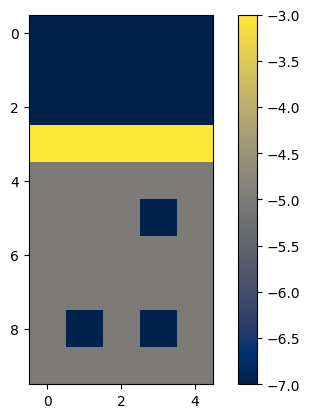

In [200]:
# set thermal diffusivity array:
kappa_arr[type_arr == 'a'] = kappa_atmosphere
kappa_arr[type_arr == 'v'] = kappa_atmosphere
kappa_arr[type_arr == 's'] = kappa_stones
kappa_arr[type_arr == 'f'] = kappa_fines

plt.imshow(np.log10(kappa_arr),cmap='cividis')
plt.colorbar();

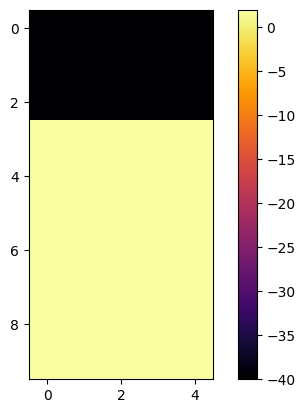

In [201]:
# set initial Temperature array:
temp_arr[type_arr=='a'] = T_a
temp_arr[type_arr !='a'] = T_0

plt.imshow(temp_arr,cmap='inferno')
plt.colorbar();

In [202]:
# pad each array to have a constant boundary
temp_arr_pad = np.pad(temp_arr,mode='edge',pad_width=1)
temp_arr_pad[-1,:] = -2

type_arr_pad = np.pad(type_arr,1,mode='constant',constant_values='b')

kappa_arr_pad = np.pad(kappa_arr,1,mode='edge')
print(type_arr_pad.shape)
type_arr_pad[1,6]

(12, 7)


'b'

## Temperature Diffusion
The Heat equation is given by:
$\frac{\partial T}{\partial t} = \kappa \nabla^2T  \\$
Discretised for 2 dimensions and using FTCS this gives 
$\Delta T_{i,j} = \kappa \Delta t (\frac{T_{i-1,j}^n - 2T_{i,j}^n+T_{i+1,j}^n}{\Delta x^2} + \frac{T_{i,j-1}^n - 2T_{i,j}^n+T_{i,j+1}^n}{\Delta z^2}$)

In [203]:
dt = min(dx**2/(8*kappa_stones),dz**2/(8*kappa_stones))
print(dt)

def solve_heat2D(T,type,kappa, dt=dt,dx=dx,dz=dz,nx=nx,nz=nz):
    dT_arr = np.zeros_like(T)
    for i in range(1, nx+1):
        for j in range(1,nz+1):
            if type[j,i] == 'a' or type[j,i] == 'b': #ignore atomsphere and boundary cells
                continue
            else:
                dTdx = (T[j,i-1] - 2*T[j,i] + T[j,i+1]) / (dx**2) # calculate T difference in  x
                dTdz = (T[j-1,i] - 2*T[j,i] + T[j+1,i]) / (dz**2) # calculate T difference in z
                
                dT_arr[j,i] = kappa[j,i]*dt*(dTdx+dTdz)

    return dT_arr

1.2500000000000002


### Testing diffusion equation on its own

In [204]:
temp_arr_pad_original = temp_arr_pad.copy()
nt = int(400000/dt)+1
print(nt)
for _ in range(nt):
    temp_arr_pad += solve_heat2D(temp_arr_pad,type_arr_pad,kappa_arr_pad)

319999


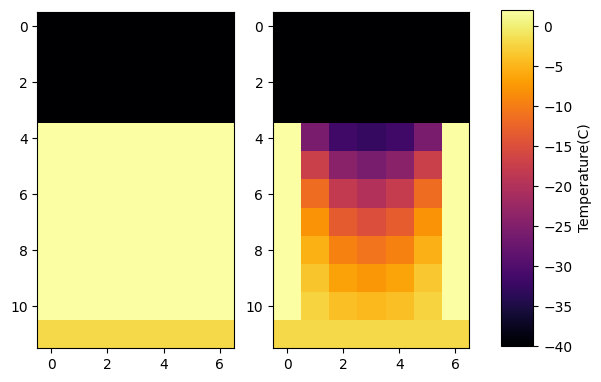

In [205]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(temp_arr_pad_original,cmap='inferno')
im = ax[1].imshow(temp_arr_pad,cmap='inferno')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax,label='Temperature(C)');

### Add Latent heat conversion

In [253]:
# Create array of amount of heat needed for full conversion of water to ice:
Q_needed = porosity*(dz*dx**2)*rho_water*L_fusion # Heat needed for a cell of all porous space filled by water

heat_arr_initial = np.zeros_like(temp_arr_pad)
heat_arr_initial[type_arr_pad=='f'] = Q_needed #set fines cells in heat array to the initial heat needed for fusion

In [254]:
def convert_T_to_heat(T,dz=dz,dx=dx,cp=cp_wet,porosity=porosity,rho_solid=rho_fines,rho_water=rho_water):
    mass = porosity*(dz*dx**2)*rho_water + (1-porosity)*(dz*dx**2)*rho_solid #calculate mass of whole cell
    return T*mass*cp

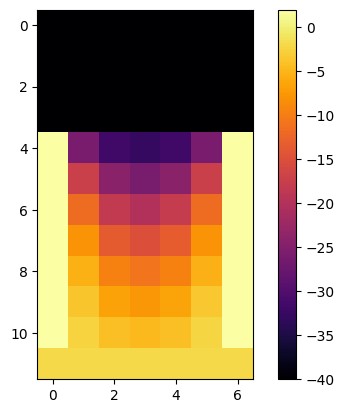

In [264]:
temp_arr_pad = temp_arr_pad_original.copy()
nt = int(400000/dt)+1
heat_arr = heat_arr_initial.copy()
for _ in range(nt):
    temp_change = solve_heat2D(temp_arr_pad,type_arr_pad,kappa_arr_pad) #calculate change in Temperature

    for i in range(1, nx+1):
        for j in range(1,nz+1):
            new_temp = temp_arr_pad[j,i] + temp_change[j,i]
            if type_arr_pad[j,i] == 'f' and heat_arr[j,i] > 0: #only look at fines cells with heat remaining
                if new_temp <=0: # check if cell would go below zero
                    heat_arr[j,i] += convert_T_to_heat(new_temp) # 'freeze' part of water to stay at zero degrees
                    new_temp = 0
            
            temp_arr_pad[j,i] = new_temp


plt.imshow(temp_arr_pad,cmap='inferno')
plt.colorbar();

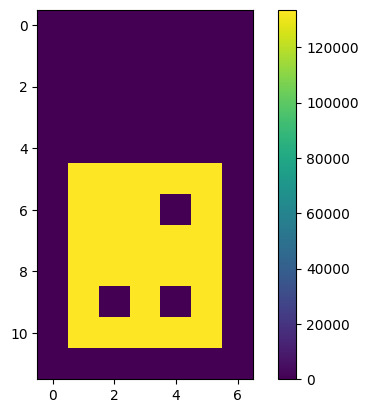

In [265]:
plt.imshow(heat_arr_initial - heat_arr)
plt.colorbar();